In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Leemos datos del csv.

In [3]:
data = pd.read_csv('phishing.csv')

Veamos que tipo de variables contiene el dataset.

In [6]:
cat = data.select_dtypes(include="object")
print(cat)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[11054 rows x 0 columns]


In [7]:
num = data.select_dtypes(exclude="object")
print(num)

       Index  UsingIP  LongURL  ShortURL  Symbol@  Redirecting//  \
0          0        1        1         1        1              1   
1          1        1        0         1        1              1   
2          2        1        0         1        1              1   
3          3        1        0        -1        1              1   
4          4       -1        0        -1        1             -1   
...      ...      ...      ...       ...      ...            ...   
11049  11049        1       -1         1       -1              1   
11050  11050       -1        1         1       -1             -1   
11051  11051        1       -1         1        1              1   
11052  11052       -1       -1         1        1              1   
11053  11053       -1       -1         1        1              1   

       PrefixSuffix-  SubDomains  HTTPS  DomainRegLen  ...  UsingPopupWindow  \
0                 -1           0      1            -1  ...                 1   
1                 -1   

Son todas numericas. Chequeamos si hay valores nulos. 

In [9]:
nulos = pd.isnull(data).sum()
print(nulos)

Index                  0
UsingIP                0
LongURL                0
ShortURL               0
Symbol@                0
Redirecting//          0
PrefixSuffix-          0
SubDomains             0
HTTPS                  0
DomainRegLen           0
Favicon                0
NonStdPort             0
HTTPSDomainURL         0
RequestURL             0
AnchorURL              0
LinksInScriptTags      0
ServerFormHandler      0
InfoEmail              0
AbnormalURL            0
WebsiteForwarding      0
StatusBarCust          0
DisableRightClick      0
UsingPopupWindow       0
IframeRedirection      0
AgeofDomain            0
DNSRecording           0
WebsiteTraffic         0
PageRank               0
GoogleIndex            0
LinksPointingToPage    0
StatsReport            0
class                  0
dtype: int64


Separamos en data y target.

In [14]:
X = np.array(data[data.columns[0:(len(data.columns) - 1)]])
print(X.shape,type(X))
y = pd.factorize(data['class'].values)[0]

(11054, 31) <class 'numpy.ndarray'>


Saco la primer variable de X: index.

In [15]:
numbers = list(range(1,32))
X = X[:,list(range(1,31))]
print(X.shape)
columns = []
for number in numbers:
    columns.append(data.columns[number])

(11054, 30)


Usaremos arbol de decisión. Vemos sus porcentajes de aciertos segun el tipo de arbol. 

In [16]:
from sklearn import tree, model_selection, metrics

np.random.seed(12)
listaAccTrain = []
listaAccTest = []

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8)

for tipoArbol in ['gini','entropy']:
    clasificador = tree.DecisionTreeClassifier(criterion=tipoArbol)
    clasificador.fit(X_train,y_train)

    prediccionesTrain = clasificador.predict(X_train)
    aciertoTrain = metrics.accuracy_score(prediccionesTrain, y_train) * 100
    prediccionesTest = clasificador.predict(X_test)
    aciertoTest = metrics.accuracy_score(prediccionesTest, y_test) * 100
    
    listaAccTrain.append(aciertoTrain)
    listaAccTest.append(aciertoTest)
    
print(listaAccTrain)
print(listaAccTest)

[99.07271288024427, 99.07271288024427]
[96.11035730438715, 96.47218453188603]


Buscamos la mejor configuración de los árboles de decisión para aboradar el problema utilizando una validación cruzada de 10 particiones.

In [77]:
semilla = np.random.seed(12)

c = tree.DecisionTreeClassifier()

params = {
    'criterion': ['gini', 'entropy'], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

clasificadores =  model_selection.GridSearchCV(c, params, scoring='accuracy', cv=10, return_train_score=True, iid=True)
clasificadores.fit(X_train,y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid=True, n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 4],
                      

In [78]:
print(clasificadores.best_score_)
print(clasificadores.best_params_)

0.9624561800294018
{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}


Probamos con random forest para comparar rendimientos

In [79]:
from sklearn.ensemble import RandomForestClassifier

clfRF = RandomForestClassifier(criterion='entropy',
                             n_estimators=100, random_state=0)
clfRF.fit(X_train,y_train)
predTrain = clfRF.predict(X_train)
predTest = clfRF.predict(X_test)
accTrainRF = metrics.accuracy_score(predTrain, y_train) * 100
accTestRF =  metrics.accuracy_score(predTest, y_test) * 100

print(accTrainRF)
print(accTestRF)

99.07271288024427
96.87924016282226


Buscamos su mejor configuracion con gridSearchCV. Ojo: demora 10 minutos aprox.

In [80]:
semilla = np.random.seed(12)
clasificador = RandomForestClassifier()

params = {'n_estimators': [10,50,100], 
          'max_features': [1,'sqrt','log2',None], 
          'criterion': ['gini','entropy'],
          'max_depth': [5,10,None],
          'min_samples_split': [2,10,20]
         }

clasificadoresRF =  model_selection.GridSearchCV(clasificador, params, scoring='accuracy', cv=10, return_train_score=True, iid=True)
clasificadoresRF.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [81]:
print(clasificadoresRF.best_score_)
print(clasificadoresRF.best_params_)

0.9731991405631573
{'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 100}


Como vemos, el rendimiento mejora un poco con random forest. Pero perdemos la simplicidad que nos dan los arboles. 
Estamos dispuestos a resignar un 1% de rendimiento para tener un clasificador mas simple?

A continuacion buscaremos las variables mas importantes. Tanto con el arbol como con el random forest. 

Arbol: Busco variables mas importantes con SelectFromModel.

In [82]:
# Se importa la función que permite seleccionar variables a partir de un modelo
from sklearn.feature_selection import SelectFromModel

# Se llama al constructor del árbol de decisión
arbolDecision = tree.DecisionTreeClassifier(criterion=clasificadores.best_params_['criterion']
                                            , min_samples_split=clasificadores.best_params_['min_samples_split']
                                            , min_samples_leaf=clasificadores.best_params_['min_samples_leaf'])
# Se aplica la selección a partir del modelo
model =  SelectFromModel(arbolDecision, threshold='median')
# Se entrena el objeto de la clase SelectFromModel
model.fit(X_train,y_train)
# Se transforman los datos originales de entrenamiento de acuerdo a las variables seleccionadas
X_new =  model.transform(X_train)
# Se obtienen las variables seleccionadas: lista de booleanos
booleanas =  model.get_support()
# Se obtienen los nombres de las variables seleccionadas

variablesSeleccionadas = [columns[i] for i in range(len(columns) - 1) if booleanas[i]==True]
print("Las variables seleccionadas son ", variablesSeleccionadas)

indicesSeleccionados = [i for i in range(len(columns) - 1) if booleanas[i]==True]

variablesDescartadas = [columns[i] for i in range(len(columns) - 1) if booleanas[i]==False]
print("Las variables descartadas son ", variablesDescartadas)

Las variables seleccionadas son  ['UsingIP', 'PrefixSuffix-', 'SubDomains', 'HTTPS', 'DomainRegLen', 'RequestURL', 'AnchorURL', 'LinksInScriptTags', 'ServerFormHandler', 'AgeofDomain', 'DNSRecording', 'WebsiteTraffic', 'PageRank', 'GoogleIndex', 'LinksPointingToPage']
Las variables descartadas son  ['LongURL', 'ShortURL', 'Symbol@', 'Redirecting//', 'Favicon', 'NonStdPort', 'HTTPSDomainURL', 'InfoEmail', 'AbnormalURL', 'WebsiteForwarding', 'StatusBarCust', 'DisableRightClick', 'UsingPopupWindow', 'IframeRedirection', 'StatsReport']


Entrenamos el arbol solo con las varables seleccionadas

In [83]:
# Llamada al constructor del árbol de decisión
arbolDecision = tree.DecisionTreeClassifier(criterion=clasificadores.best_params_['criterion']
                                            , min_samples_split=clasificadores.best_params_['min_samples_split']
                                            , min_samples_leaf=clasificadores.best_params_['min_samples_leaf'])
# Entrenamiento del árbol de decisión con los datos transformados
arbolDecision.fit(X_new,y_train)
# Predicción de las clases de los datos de entrenamiento transformados
prediccionesTrain = arbolDecision.predict(X_new)
# Se obtiene el accuracy en enrenamiento del nuevo árbol
accuracyTrain = metrics.accuracy_score(prediccionesTrain, y_train) * 100
print(accuracyTrain)

# Obtenición del rendimiento con los datos de test
prediccionesTest = arbolDecision.predict(X_test[:,indicesSeleccionados])
accuracyTest = metrics.accuracy_score(prediccionesTest, y_test) * 100
print(accuracyTest)

98.49598552527424
95.52238805970148


Perdemos un 1% de rendimiento pero utilizamos 15 variables menos.

RandomForest:

La importancia de la variable SubDomains es: 28.05178
La importancia de la variable RequestURL es: 24.69208
La importancia de la variable DNSRecording es: 7.53289
La importancia de la variable PrefixSuffix- es: 6.2756
La importancia de la variable Redirecting// es: 5.07035
La importancia de la variable AnchorURL es: 4.56172
La importancia de la variable LinksInScriptTags es: 2.45978
La importancia de la variable GoogleIndex es: 2.20592
La importancia de la variable HTTPSDomainURL es: 1.97316
La importancia de la variable IframeRedirection es: 1.77009
La importancia de la variable HTTPS es: 1.67463
La importancia de la variable Index es: 1.56259
La importancia de la variable WebsiteTraffic es: 1.44934
La importancia de la variable AgeofDomain es: 1.43154
La importancia de la variable PageRank es: 1.43135
La importancia de la variable UsingIP es: 1.03293
La importancia de la variable NonStdPort es: 0.7012
La importancia de la variable AbnormalURL es: 0.64803
La importancia de la variable

<BarContainer object of 30 artists>

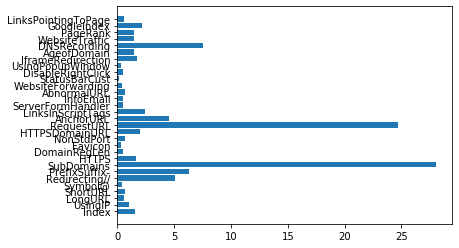

In [84]:
importancias = clfRF.feature_importances_ * 100
# Vamos a emparejar cada valor con el nombre de cada variable (cada pareja será una tupla)
variables_importancia = [(nombreVar, round(importancia, 5)) for nombreVar, importancia in 
                         zip(data.columns, importancias)]
# Vamos a ordenar las variable de acuerdo a su importancia (de mayor a menor importancia)
variables_importancia_ordenado = sorted(variables_importancia, key = lambda x: x[1], reverse = True)
# Imprimimos el nombre de cada variable y su importancia
for nomVar, imp in variables_importancia_ordenado:
    print("La importancia de la variable {} es: {}".format(nomVar, imp))

# Creamos una figura de barras horizontales (plt.barh) con la misma información (sin ordenar por importancia: orden original de variables)
    # Para etiquetar cada barra podéis utilizar el comando plt.yticks y poner el nombre de cada variable en cada caso
plt.barh(np.array(variables_importancia)[:,0], importancias)

Como podemos vee las primeras 15 variables son casi las mismas que las que elige el arbol. Difieren solamente en una. 
